# Imports

In [80]:
import pandas as pd
import numpy as np
import random
random.seed(42)
#Suppress scientific notation
pd.options.display.float_format = '{:.1f}'.format

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import scipy.stats as scs

# Progress bars
import time
from tqdm import tqdm

# Remove warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Functions

In [2]:
# Customize dataset in one line
def get_df(df, zipcode=None, city=None, state_initials=None, metro=None, county=None, start=None, end=None):
    '''
    Input: 
    df: dataframe with format from 'zillow_data.csv' 
    zipcode: int, 5 digits
    city: string
    state_initials: string, 2 capital letters
    metro: string
    county: string
    start: string, date format 'YYYY-MM'
    end: string, date format 'YYYY-MM'
    
    Returns:
    Dataframe of given location parameters and start/end dates
    '''
    data = df.copy()
    #Find specified location
    if zipcode:
        data = data.loc[(df.RegionName == zipcode)]
    if city:
        data = data.loc[(df.City == city)]
    if state_initials:
        data = data.loc[(df.State == state_initials)]
    if metro: 
        data = data.loc[(df.Metro == metro)]
    if county:
        data = data.loc[(df.CountyName == county)]
    #Drop unnecessary columns
    data.drop(columns=['RegionID', 'SizeRank'], inplace=True)
    #Split dataframe into location information and house values
    head = data.iloc[:,:5]
    tail = data.iloc[:,5:]
    #Limit time range to given start/end dates
    if start:
        #Get index of start date
        i = tail.columns.get_loc(start)
    else:
        i = None
    if end:
        #Get index of end date
        j = tail.columns.get_loc(end) + 1
    else:
        j = None
    #Slice tail with given start/end indexes
    tail = tail.iloc[:,i:j]
    #Combine head and tail
    new_df = pd.concat([head, tail], axis=1)
    #Set zipcode as index
    new_df.set_index('RegionName', inplace=True)
    return new_df

In [3]:
# Convert dataframe to a usable format for time series analysis
def make_time_series(df):
    '''
    Input:
    Dataframe with format from 'zillow_data.csv' 
    
    Return:
    Time series format with 
    index set as Month and 
    columns for each zipcode in df
    '''
    ts = pd.DataFrame()
    #Set column Month to dates from column names in df, convert to datetime
    ts['Month'] = pd.to_datetime(df.columns.values[4:], format='%Y-%m')
    for zipcode in df.index:
        #For each zipcode, find all the housing values
        row = df[df.index==zipcode].iloc[:,4:]
        #Make column for each zipcode with housing values
        ts[zipcode] = row.values[0]
    ts.set_index('Month',inplace=True)
    return ts

In [4]:
# Plot timeseries of house value by zipcode
def plot_time_series(ts, region_name=None, line=True, boxplot=True, figsize=(12,8)):
    '''
    Plot line graph and boxplot of time series region
    
    Input:
    ts: time series format
    region_name: string, name of target region
    line: boolean, plot line graph
    boxplot: boolean, plot boxplot
    figsize: default (12,8)
    '''
    if line:
        # Generate line graph for each zipcode
        ts.plot(figsize=figsize)
        if region_name:
            plt.title("Median Home Value by Zip Code in {}".format(region_name))
        else:
            plt.title("Median Home Value")
        plt.show()

    if boxplot:
        # Generate a box and whiskers plot for each zipcode
        ts.boxplot(figsize = figsize)
        if region_name:
            plt.title("Median Home Value by Zip Code in {}".format(region_name))
        else:
            plt.title("Median Home Value")
        plt.show()

In [5]:
def decompose_time_series(ts, figsize=(12,4), mean=False):
    if mean==True:
        decomposition = seasonal_decompose(ts.mean(axis=1))
    else:
        decomposition = seasonal_decompose(ts)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    trend.plot(figsize=figsize)
    plt.title("Trend")
    plt.xlabel("Year")
    plt.show()

    seasonal.plot(figsize=figsize)
    plt.title("Seasonality")
    plt.xlabel("Year")
    plt.show()

    residual.plot(figsize=figsize)
    plt.title("Residual")
    plt.xlabel("Year")
    plt.show()

In [6]:
def train_test_split(ts, len_test):
    train, test = ts[:-len_test], ts[-len_test:]
    print("Train Test Split Complete \nLength of Train: {} \tLength of Test: {}".format(len(train), len(test)))
    return train, test

In [7]:
# create a list of parameters to try
def param_combinations(param_range=3, differencing_range=2, seasonal=[0,12], trend=[None,'t','ct']):
    '''
    Creates combinations of parameters for SARIMAX modeling
    
    Input: 
        param_range: int, range for p, q, P, Q (default 3=[0,1,2])
        differencing_range: int, range for d and D (default 2=[0,1])
        seasonal: list, default [0,12]
        trend: list, default [None,'t','ct']
            None - SARIMAX default
            't' - linear trend
            'ct' - linear trend with constant
            *Note: to use only None, enter [None]
        
    Return:
        list in this format: [(p,d,q), (P,D,Q,s), t]
    '''
    p = q = P = Q = range(param_range) #default 3 [0,1,2]
    d = D = range(differencing_range) #default 2 [0,1]
    s = seasonal #default [0,12]
    t = trend #default [None,'t','ct']
    params = []
    # create config instances
    for p_ in tqdm(p, desc='Making parameter combinations', leave=False):
        for d_ in d:
            for q_ in q:
                for t_ in t:
                    for P_ in P:
                        for D_ in D:
                            for Q_ in Q:
                                for s_ in s:
                                    combo = [(p_,d_,q_), (P_,D_,Q_,s_), t_]
                                    params.append(combo)
    return params

In [8]:
# root mean squared error or rmse
def measure_rmse(true_values, predictions):
    return np.sqrt(mean_squared_error(true_values, predictions))

In [9]:
def sarimax(ts, order, sorder, trend=None):
    '''
    Fits a Statsmodels SARIMAX Time Series Model.
    
    Inputs:
        ts: time series format
        order: list containing the p,d,and q values for the SARIMAX function.
        sorder: list containing the seasonal p,d and q values along with seasonal 
            shift amount for the SARIMAX function
        trend: string, options=[None, 'n', 'c', 'ct', 't']
    
    Return:
        fitted model
    '''
    #Run and fit SARIMAX model with given parameters
    model = sm.tsa.statespace.SARIMAX(ts, order=order, seasonal_order=sorder, trend=trend, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    fit_model = model.fit(disp=False)
    return fit_model

def sarimax_model(ts, order, sorder, trend=None):
    '''
    Fits a Statsmodels SARIMAX Time Series Model.
    
    Inputs:
        ts: time series format
        order: list containing the p,d,and q values for the SARIMAX function.
        sorder: list containing the seasonal p,d and q values along with seasonal 
            shift amount for the SARIMAX function
        trend: string, options=[None, 'n', 'c', 'ct', 't']
    
    Return:
        Dictionary containing:
        ['model', 'order', 'sorder', 'trend', 'AIC', 'BIC']
        If SARIMAX failed to execute:
            Set model=None, AIC=999999, and BIC=999999
    '''
    try:
        #Run and fit SARIMAX model with given parameters
        model = sm.tsa.statespace.SARIMAX(ts, order=order, seasonal_order=sorder, trend=trend, 
                                          enforce_stationarity=False, enforce_invertibility=False)
        fit_model = model.fit(disp=False)
        #Add relevant information to dictionary
        row = {'model':fit_model,'order':order,'sorder':sorder,'trend':trend,
                'AIC':fit_model.aic,'BIC':fit_model.bic}
    except:
        #If error, set 'model'=None, 'AIC'=999999 and 'BIC'=999999
        row = {'model':None,'order':order,'sorder':sorder,'trend':trend,
                'AIC':999999,'BIC':999999}
    return row

def model_cross_validation(ts, order, sorder, trend=None, n_splits=4):
    '''
    Uses time series cross validation (TimeSeriesSplit) of n_splits.
    Calculates RMSE for each split
    Adds average RMSE over all splits to row of modeling results
    *Remember to reserve a portion of the data for final model evaluation
    
    Input:
        ts - full time series
        order - ints, (#,#,#)
        sorder - ints, (#,#,#,#)
        trend - string
        n_splits - number of cross validation splits (default 4)
        
    Returns:
        Dictionary (row) of modeling results
    '''
    #Initialize TimeSeriesSplit with n_splits (default 4)
    tscv = TimeSeriesSplit(n_splits = n_splits)
    #Create list for RMSE of each cross validation split
    rmse = []
    #Use tscv to implement Forward Chaining Nested Cross Validation
    for train_index, test_index in tscv.split(ts):
        #Make train, test split for section
        cv_train, cv_test = ts.iloc[train_index], ts.iloc[test_index]
        #Run model for section, produce dictionary with fitted model, parameters, AIC, and BIC
        run = sarimax_model(cv_train, order, sorder, trend)
        #Store fitted model in variable
        model = row['model']
        #If SARIMAX executes, calculate root mean squared error of section and append it to list
        if model:
            predictions = model.predict(cv_test.index.values[0], cv_test.index.values[-1])
            true_values = cv_test.values
            rmse.append(measure_rmse(true_values, predictions))
        #If SARIMAX fails, append 999999
        else:
            rmse.append(999999)
    #Calculate mean from RMSEs of cross validations
    cv_rmse = np.mean(rmse)
    #Add CV_RMSE to dictionary
    row['CV_RMSE'] = cv_rmse
    #Returns dictionary of modeling results
    return row

In [10]:
def cross_validation_rmse(ts, order, sorder, trend=None, n_splits=4):
    '''
    Uses time series cross validation (TimeSeriesSplit) of n_splits.
    Calculates RMSE for each split
    *Remember to reserve a portion of the data for final model evaluation
    
    Input:
        ts - full time series
        order - ints, (#,#,#)
        sorder - ints, (#,#,#,#)
        trend - string
        n_splits - number of cross validation splits (default 4)
        
    Returns:
        Average root mean squared error of cross validations 
    '''
    #Initialize TimeSeriesSplit with n_splits (default 4)
    tscv = TimeSeriesSplit(n_splits = n_splits)
    #Create list for RMSE of each cross validation split
    rmse = []
    try:
        #Use tscv to implement Forward Chaining Nested Cross Validation
        for train_index, test_index in tscv.split(ts):
            #Make train, test split for section
            cv_train, cv_test = ts.iloc[train_index], ts.iloc[test_index]
            #Run and fit model for section
            model = sarimax(cv_train, order, sorder, trend)
            #Get predictions from model for cv_test date range
            predictions = model.predict(cv_test.index.values[0], cv_test.index.values[-1])
            #Store true values for cv_test date range
            true_values = cv_test.values
            #Calculate RMSE and append to list
            rmse.append(measure_rmse(true_values, predictions))
        #Calculate average of RMSEs from cross validations
        cv_rmse = round(sum(rmse)/n_splits,3)
    except:
        cv_rmse = np.nan
    
    return cv_rmse

In [11]:
def results_dict(ts, order, sorder, trend):
    cv_rmse = cross_validation_rmse(ts, order, sorder, trend)
    model = sarimax(ts, order, sorder, trend)
    aic = model.aic
    bic = model.bic
    dictionary = {'model':model,'order':order,'sorder':sorder,'trend':trend,
                'AIC':aic,'BIC':bic, 'CVRMSE':cv_rmse}
    return dictionary

def run_models(ts, param_combos):
    '''
    Function to run SARIMAX model with cross validation for all parameter combinations
    for single time series
    Input:
        ts: single time series
        param_combos: list of parameter combinations
            format: order, sorder, trend
            
    '''
    #Initialize list for results
    results = []
    #Iterate through parameters with progress baar
    for param in tqdm(param_combos, desc='Running models with cross validation', 
                      leave=False):
        #Separate parameters
        order, sorder, trend = param
        #Run model with cross validation
        result = model_cross_validation(ts, order, sorder, trend)
        #Add dictionary of result to list
        results.append(result)
    #Convert list of dictionaries to dataframe
    df = pd.DataFrame(results, columns=['model', 'order', 'sorder', 'trend', 'AIC', 
                                        'BIC', 'CV_RMSE'])
    return df

In [12]:
def run_models_by_params(ts, param_combos):
    '''
    Function to run SARIMAX model with cross validation for all parameter combinations
    for single time series
    Input:
        ts: single time series (training data)
        param_combos: list of parameter combinations
            format: order, sorder, trend
            
    '''
    #Initialize list for results
    results = []
    #Iterate through parameters with progress baar
    for param in tqdm(param_combos, desc='Running models with cross validation', leave=False):
        #Separate parameters
        order, sorder, trend = param
        #Run model with cross validation
        result = results_dict(ts, order, sorder, trend)
        #Add dictionary of result to list
        results.append(result)
    #Convert list of dictionaries to dataframe
    df = pd.DataFrame(results, columns=['model', 'order', 'sorder', 'trend', 'AIC', 'BIC', 'CVRMSE'])
    return df

In [13]:
def run_all_models(ts_all, param_combos):
    '''
    Function to iterate through zipcodes and run SARIMAX models with cross validation 
    for all combinations of parameters
    
    Input:
        ts - time series of region (training data)
        param_combos - list of parameter combinations
    '''
    #Initialize list for rows
    df_list = []
    #Iterate through the columns in the time seres
    for zipcode in tqdm(ts_all.columns, desc='Modeling zipcodes', leave=False):
        #Sanity check
        print(f'Running models for zipcode {zipcode}')
        #Isolate the data for the zipcode
        ts = ts_all[zipcode]
        #Iterate through all param_combos using time series cross validation
        #Stores row as dataframe with results of model
        zip_df = run_models_by_params(ts, param_combos)
        #Add column for zipcode to dataframe
        zip_df.insert(0, 'zipcode', zipcode)
        #Add row to df_list
        df_list.append(zip_df)
    #Combine zip_df into dataframe
    df = pd.concat(df_list)
    return df

In [41]:
def rmse_final(train, test, order, sorder, trend):
    model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=sorder, trend=None, 
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    fit_model = model.fit(disp=False)
    #Get predictions from model for test date range
    predictions = fit_model.predict(test.index.values[0], test.index.values[-1])
    #Store true values for test date range
    true_values = test.values
    rmse = measure_rmse(true_values, predictions)
    return rmse

In [286]:
def sort_best_models(results_df, criterion, drop_duplicates=True):
    '''
    Input:
        df - dataframe of all model results
        criterion - string, column name to sort by
        
    Returns:
        Dataframe of best model results for each zipcode
    '''
    df = results_df.copy()
    #Drop nan values in CVRMSE columns
    df.dropna(subset=['CVRMSE'], inplace=True)
    #Sort values by given criterion
    df.sort_values(criterion, ascending=True, inplace=True)
    if drop_duplicates:
        #Get top row for each zipcode
        df.drop_duplicates(['zipcode'], inplace=True)
    #Fill null values with None (affects trend)
    df.fillna('None', inplace=True)
    return df

In [16]:
def extract_params(results_df, zipcode):
    '''
    Input:
        best_results - Dataframe from running models
        zipcode - int, 5 digits
        
    Returns:
        order, seasonal_order, trend
    '''
    row = results_df.loc[results_df['zipcode']==zipcode]
    order = (int(row['order'].values[0][1]),
            int(row['order'].values[0][4]),
            int(row['order'].values[0][7]))
    sorder = (int(row['sorder'].values[0][1]),
            int(row['sorder'].values[0][4]),
            int(row['sorder'].values[0][7]),
            int(row['sorder'].values[0][10:12]))
    trend = str(row['trend'].values[0])    
    print(f'zipcode: {zipcode}, order: {order}, sorder: {sorder}, trend: {trend}')
    
    return order,sorder,trend

## Load data and isolate region

In [274]:
#Load zillow data
raw_df = pd.read_csv('zillow_data.csv')
#Get desired subset of zipcodes
df = get_df(raw_df, state_initials='DC')
#Set region_name
region_name = 'DC'
#Check length of subset
print("Number of zipcodes in region: {}".format(len(df)))
raw_df.head()

Number of zipcodes in region: 18


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Format and clean data

In [275]:
#Create dataframe in time series format
ts_all = make_time_series(df)
display(ts_all.head())
#Check data types
display(ts_all.info())
#Check for null placeholders
display(ts_all.describe())
#Check for null values
nulls = df.isna().sum().sum()
print('Count of null values: {}'.format(nulls))
#Take extra steps here to handle null values if necessary

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
Month,,,,,,,,,,,,,,,,,,
1996-04-01,94300.0,178800.0,118900.0,91300.0,92000.0,104500.0,450100.0,130000.0,85700.0,362000.0,110500.0,358100.0,209800.0,121700.0,123000.0,277800.0,312400.0,185000.0
1996-05-01,94000.0,179200.0,118500.0,91000.0,92600.0,103800.0,448200.0,130100.0,85500.0,361200.0,111200.0,356000.0,208200.0,121400.0,122400.0,275800.0,311000.0,184900.0
1996-06-01,93700.0,179600.0,118200.0,90600.0,93200.0,103000.0,446300.0,130200.0,85400.0,360300.0,112000.0,353900.0,206600.0,121200.0,121800.0,273700.0,309800.0,184700.0
1996-07-01,93600.0,180000.0,117800.0,90400.0,93900.0,102200.0,444500.0,130400.0,85200.0,359400.0,112900.0,351700.0,205000.0,121000.0,121200.0,271600.0,308700.0,184400.0
1996-08-01,93400.0,180300.0,117600.0,90100.0,94600.0,101400.0,442900.0,130600.0,85000.0,358500.0,113800.0,349600.0,203300.0,120900.0,120700.0,269500.0,307900.0,184100.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 18 columns):
20002    265 non-null float64
20009    265 non-null float64
20011    265 non-null float64
20019    265 non-null float64
20001    265 non-null float64
20020    265 non-null float64
20008    265 non-null float64
20003    265 non-null float64
20032    265 non-null float64
20016    265 non-null float64
20010    265 non-null float64
20007    265 non-null float64
20024    265 non-null float64
20017    265 non-null float64
20018    265 non-null float64
20037    265 non-null float64
20015    265 non-null float64
20012    265 non-null float64
dtypes: float64(18)
memory usage: 39.3 KB


None

,20002,20009,20011,20019,20001,20020,20008,20003,20032,20016,20010,20007,20024,20017,20018,20037,20015,20012
count,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0,265.0
mean,334891.7,610009.1,310201.1,175588.3,384943.8,200793.6,1082671.7,478972.1,174957.7,811999.2,401186.4,877087.9,527157.7,293233.2,294817.4,660361.1,730394.7,434212.1
std,172648.3,255816.6,136781.1,61102.0,203111.5,69213.7,329621.0,211266.4,62684.7,253033.3,195092.6,289807.8,207249.7,122808.3,122242.5,216826.8,216779.6,157999.5
min,93400.0,178800.0,117400.0,89200.0,92000.0,99200.0,440100.0,130000.0,82500.0,356400.0,110500.0,342900.0,194800.0,120900.0,120200.0,262000.0,307300.0,183700.0
25%,148400.0,370300.0,169500.0,118300.0,168600.0,129100.0,873100.0,280300.0,118700.0,591900.0,192100.0,642500.0,333900.0,166500.0,159200.0,480400.0,562100.0,292100.0
50%,370600.0,700300.0,320100.0,178000.0,416900.0,206300.0,1229300.0,556500.0,174800.0,917200.0,437100.0,991900.0,588300.0,307200.0,304200.0,758100.0,827600.0,471700.0
75%,410500.0,753000.0,396800.0,222000.0,472200.0,259000.0,1316100.0,612300.0,228300.0,953200.0,489200.0,1058600.0,643500.0,373900.0,384100.0,804100.0,871700.0,547000.0
max,691300.0,1081000.0,619100.0,314100.0,793300.0,337000.0,1545900.0,820200.0,308200.0,1215900.0,778200.0,1330800.0,900700.0,548900.0,554100.0,1019600.0,1007200.0,730700.0


Count of null values: 0


## Visualize data

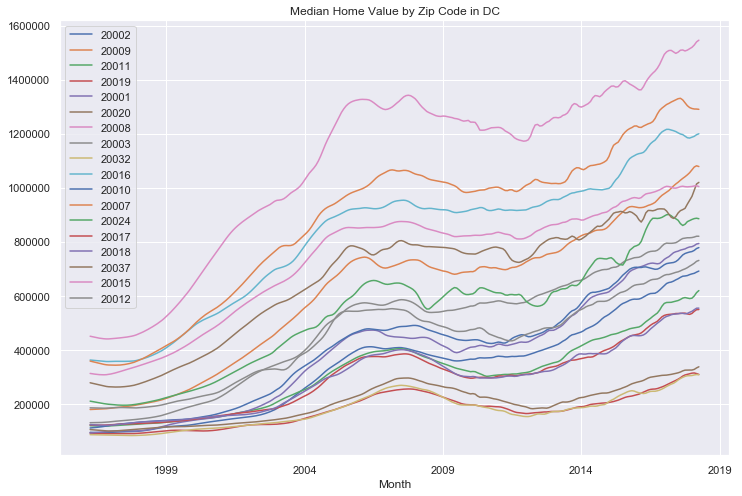

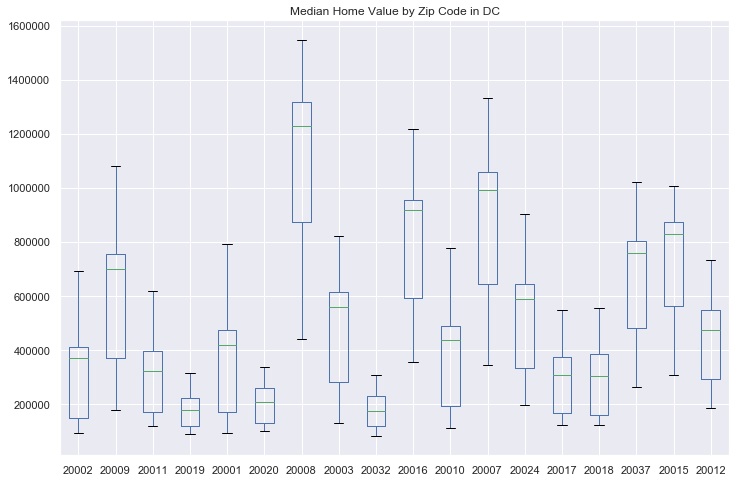

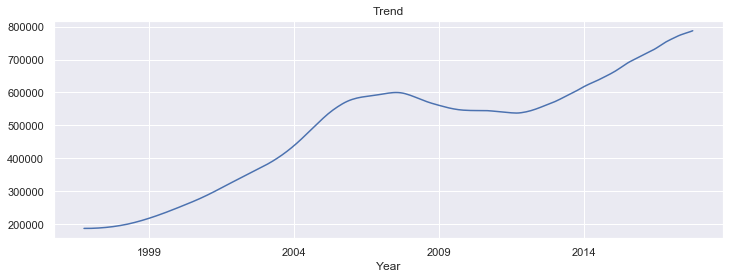

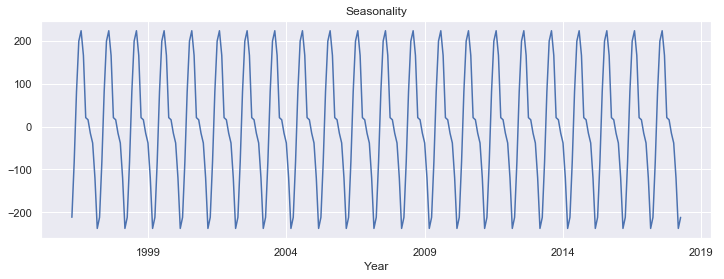

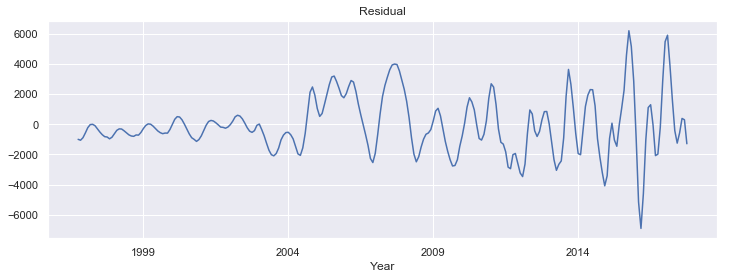

In [276]:
#Plot the time series with line graph and boxplot
plot_time_series(ts_all, region_name=region_name, line=True, boxplot=True)

#Plot decomposition of time series
##To plot mean of region, set ts=ts_all and mean=True
##Otherwise use single time series
decompose_time_series(ts_all, mean=True)

**Observations:**

* There is a clear positive trend and seasonality. 
* The 2008 housing market crash is apparent in the data. The market rebounds around 2012.
* The box plot shows the historical distribution of housing values by zipcode, illustrating which zipcodes have seen the biggest change in value.

## Optimize parameters

In [277]:
#Reserve 12 months for final testing
cross_validation, test = train_test_split(ts_all, 12)

Train Test Split Complete 
Length of Train: 253 	Length of Test: 12


In [278]:
#Create combinations of parameters
param_combos = param_combinations(seasonal=[12], trend=[None])
#Check length of combinations
print('Total parameter combinations: {}'.format(len(param_combos)))

Total parameter combinations: 324


### Experiment with small subset of zipcodes and parameter combinations

#EXPERIMENT 
#Make random subset of zipcodes and parameters
zipcodes = set(ts_all.columns)
z = random.sample(zipcodes,6)
ps = random.sample(param_combos,5)
z_ts = cross_validation[z]
z_test = test[z]

#EXPERIMENT
#Iterate through all parameter combinations for all zipcodes
test_all_models = run_all_models(z_ts, ps)
#Save dataframe of all model results to csv file for future work
test_all_models.to_csv('test_all_models.csv', index=False)

#EXPERIMENT
#Read dataframe with all model results
test_all_df = pd.read_csv('test_all_models.csv').round(1)
test_all_df

#Sort by desired criterion to find best model for each zipcode
test_best_results = sort_best_models(test_all_df, 'AIC', drop_duplicates=True)
test_best_results

In [46]:
rmse_list = []
for zipcode in test_best_results.zipcode:
    o,s,t = extract_params(best_results, zipcode)
    rmse = rmse_final(cross_validation[zipcode], test[zipcode], o, s, t)
    rmse_list.append(rmse)
test_best_results['RMSE'] = np.round(rmse_list,1)
test_best_results

zipcode: 20032, order: (2, 0, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20017, order: (2, 0, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20018, order: (2, 0, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20002, order: (2, 0, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20001, order: (2, 0, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20024, order: (2, 0, 2), sorder: (1, 0, 0, 12), trend: None


,zipcode,model,order,sorder,trend,AIC,BIC,CVRMSE,RMSE
17,20032,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 0, 2)","(1, 0, 0, 12)",None,3740.3,3761.2,82984.3,3138.0
12,20017,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 0, 2)","(1, 0, 0, 12)",None,3780.5,3801.3,305799.3,4062.4
22,20018,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 0, 2)","(1, 0, 0, 12)",None,3784.8,3805.7,83937.2,20673.4
7,20002,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 0, 2)","(1, 0, 0, 12)",None,3848.4,3869.2,133671.9,3226.0
27,20001,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 0, 2)","(1, 0, 0, 12)",None,3922.8,3943.7,149728.9,23865.2
2,20024,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(2, 0, 2)","(1, 0, 0, 12)",None,4300.2,4321.0,103021.5,18940.3


### Optimize over full region with all parameter combinations

In [47]:
#Break reagion into smaller sections for easier processing
ts1 = ts_all.iloc[:,:6]
ts2 = ts_all.iloc[:,6:12]
ts3 = ts_all.iloc[:,12:18]
print(f'''Verify all columns are accounted for: 
      {len(ts_all.columns) == len(ts1.columns) + len(ts2.columns) + len(ts3.columns)}''')

Verify all columns are accounted for: 
      True


In [25]:
#Drop problematic zipcode (figure out how to fix later)
#ts2.drop(20003, axis=1, inplace=True)

#THIS CELL TAKES A VERY LONG TIME TO RUN
#Iterate through all parameter combinations for subset of zipcodes
ts1_models = run_all_models(ts1, param_combos)
#Save dataframe of ts1 model results to csv file for future work
ts1_models.to_csv('ts1_models.csv', index=False)

#THIS CELL TAKES A VERY LONG TIME TO RUN
#Iterate through all parameter combinations for subset of zipcodes
ts2_models = run_all_models(ts2, param_combos)
#Save dataframe of ts2 model results to csv file for future work
ts2_models.to_csv('ts2_models.csv', index=False)

#THIS CELL TAKES A VERY LONG TIME TO RUN
#Iterate through all parameter combinations for subset of zipcodes
ts3_models = run_all_models(ts3, param_combos)
#Save dataframe of ts3 model results to csv file for future work
ts3_models.to_csv('ts3_models.csv', index=False)

In [246]:
#Read csv files for all model results
cols = list(pd.read_csv("ts1_models.csv", nrows =1))
ts1_models_df = pd.read_csv('ts1_models.csv', usecols =[i for i in cols if i != 'model']).round(1)
ts2_models_df = pd.read_csv('ts2_models.csv', usecols =[i for i in cols if i != 'model']).round(1)
ts3_models_df = pd.read_csv('ts3_models.csv', usecols =[i for i in cols if i != 'model']).round(1)

In [247]:
#Combine all model results
all_models_df = pd.concat([ts1_models_df, ts2_models_df, ts3_models_df])
all_models_df.head()
print(f'''Verify all data is accounted for: 
    {len(all_models_df) == len(ts1_models_df) + len(ts2_models_df) + len(ts3_models_df)}''')

Verify all data is accounted for: 
    True


In [250]:
all_models_df.rename(columns={'CV_RMSE':'CVRMSE'}, inplace=True)

In [251]:
all_models_df.head()

,zipcode,order,sorder,trend,AIC,BIC,CVRMSE
0,20002,"(0, 0, 0)","(0, 0, 0, 12)",nan,5924.2,5927.6,395446.4
1,20002,"(0, 0, 0)","(0, 0, 1, 12)",nan,5473.9,5480.5,379658.0
2,20002,"(0, 0, 0)","(0, 0, 2, 12)",nan,8709.1,8718.8,28449668.8
3,20002,"(0, 0, 0)","(0, 1, 0, 12)",nan,4739.7,4743.0,99050.9
4,20002,"(0, 0, 0)","(0, 1, 1, 12)",nan,4466.9,4473.4,99035.7


In [287]:
all_models_df.isna().sum()

zipcode       0
order         0
sorder        0
trend      5508
AIC           0
BIC           0
CVRMSE        0
dtype: int64

In [291]:
best_results1 = sort_best_models(all_models_df, 'AIC', drop_duplicates=True)
best_results1

,zipcode,order,sorder,trend,AIC,BIC,CVRMSE
1175,20019,"(1, 1, 2)","(0, 1, 2, 12)",None,2496.8,2515.7,30087518.1
539,20032,"(1, 1, 2)","(2, 1, 2, 12)",None,2585.9,2611.1,62154315099867.4
851,20018,"(1, 1, 2)","(0, 1, 2, 12)",None,2661.9,2680.8,14271886953242934.0
527,20017,"(1, 1, 2)","(0, 1, 2, 12)",None,2677.6,2696.4,371075.2
857,20011,"(1, 1, 2)","(1, 1, 2, 12)",None,2695.0,2717.0,25120652.7
203,20002,"(1, 1, 2)","(0, 1, 2, 12)",None,2725.3,2744.2,154462213.1
1505,20015,"(1, 1, 2)","(1, 1, 2, 12)",None,2769.9,2791.9,198685213708696.0
1835,20020,"(1, 1, 2)","(2, 1, 2, 12)",None,2782.3,2807.5,15751735915470596318424754890497615035108717034...
1187,20010,"(1, 1, 2)","(2, 1, 2, 12)",None,2793.0,2818.2,331590.1
1823,20012,"(1, 1, 2)","(0, 1, 2, 12)",None,2799.8,2818.6,7598460333684.7


In [288]:
#Sort all results by desired criterion
#Return dataframe with one row for each zipcode
best_results = sort_best_models(all_models_df, 'CVRMSE', drop_duplicates=True)
best_results

,zipcode,order,sorder,trend,AIC,BIC,CVRMSE
1714,20020,"(0, 1, 2)","(0, 1, 1, 12)",None,3013.3,3026.1,20792.7
1110,20019,"(1, 0, 1)","(2, 0, 0, 12)",None,3171.0,3187.2,27567.8
463,20032,"(1, 0, 1)","(2, 0, 1, 12)",None,3226.2,3245.6,27568.1
1447,20015,"(1, 0, 2)","(1, 0, 1, 12)",None,3704.0,3723.7,28434.5
1879,20012,"(2, 0, 2)","(1, 0, 1, 12)",None,3274.8,3297.8,35953.6
793,20018,"(1, 0, 2)","(0, 0, 1, 12)",None,3486.5,3502.9,37787.7
457,20017,"(1, 0, 1)","(1, 0, 1, 12)",None,3514.6,3531.0,46329.6
226,20002,"(2, 0, 0)","(1, 1, 1, 12)",None,3151.2,3167.3,46966.6
606,20009,"(2, 1, 0)","(2, 0, 0, 12)",None,3053.2,3069.3,51353.9
907,20016,"(2, 0, 2)","(1, 0, 1, 12)",None,3643.6,3666.6,52217.4


## Select 5 best zipcodes

In [290]:
rmse_list = []
all_models_df.dropna(subset=['CVRMSE'], inplace=True)
for zipcode in best_results.zipcode:
    o,s,t = extract_params(best_results, zipcode)
    rmse = rmse_final(cross_validation[zipcode], test[zipcode], o, s, t)
    rmse_list.append(rmse)
best_results['RMSE'] = np.round(rmse_list,1)
best_results

zipcode: 20020, order: (0, 1, 2), sorder: (0, 1, 1, 12), trend: None
zipcode: 20019, order: (1, 0, 1), sorder: (2, 0, 0, 12), trend: None
zipcode: 20032, order: (1, 0, 1), sorder: (2, 0, 1, 12), trend: None
zipcode: 20015, order: (1, 0, 2), sorder: (1, 0, 1, 12), trend: None
zipcode: 20012, order: (2, 0, 2), sorder: (1, 0, 1, 12), trend: None
zipcode: 20018, order: (1, 0, 2), sorder: (0, 0, 1, 12), trend: None
zipcode: 20017, order: (1, 0, 1), sorder: (1, 0, 1, 12), trend: None
zipcode: 20002, order: (2, 0, 0), sorder: (1, 1, 1, 12), trend: None
zipcode: 20009, order: (2, 1, 0), sorder: (2, 0, 0, 12), trend: None
zipcode: 20016, order: (2, 0, 2), sorder: (1, 0, 1, 12), trend: None
zipcode: 20037, order: (2, 1, 1), sorder: (2, 0, 1, 12), trend: None
zipcode: 20007, order: (1, 1, 2), sorder: (0, 0, 1, 12), trend: None
zipcode: 20024, order: (2, 1, 2), sorder: (2, 0, 0, 12), trend: None
zipcode: 20011, order: (2, 1, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20010, order: (2, 1, 1), 

,zipcode,order,sorder,trend,AIC,BIC,CVRMSE,RMSE
1714,20020,"(0, 1, 2)","(0, 1, 1, 12)",None,3013.3,3026.1,20792.7,2373.5
1110,20019,"(1, 0, 1)","(2, 0, 0, 12)",None,3171.0,3187.2,27567.8,10511.7
463,20032,"(1, 0, 1)","(2, 0, 1, 12)",None,3226.2,3245.6,27568.1,13059.2
1447,20015,"(1, 0, 2)","(1, 0, 1, 12)",None,3704.0,3723.7,28434.5,13426.6
1879,20012,"(2, 0, 2)","(1, 0, 1, 12)",None,3274.8,3297.8,35953.6,15356.6
793,20018,"(1, 0, 2)","(0, 0, 1, 12)",None,3486.5,3502.9,37787.7,20648.6
457,20017,"(1, 0, 1)","(1, 0, 1, 12)",None,3514.6,3531.0,46329.6,25530.6
226,20002,"(2, 0, 0)","(1, 1, 1, 12)",None,3151.2,3167.3,46966.6,18930.9
606,20009,"(2, 1, 0)","(2, 0, 0, 12)",None,3053.2,3069.3,51353.9,10204.4
907,20016,"(2, 0, 2)","(1, 0, 1, 12)",None,3643.6,3666.6,52217.4,18192.0


# Everything below here is unfinished and breaking

In [300]:
order,sorder,trend = extract_params(best_results, 20020)
model = sm.tsa.statespace.SARIMAX(ts_all, order=order, seasonal_order=sorder, trend=None, 
                                    enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit()
    

zipcode: 20020, order: (0, 1, 2), sorder: (0, 1, 1, 12), trend: None


ValueError: Invalid value for design matrix. Requires a 2- or 3-dimensional array, got 1 dimensions

In [302]:
rows = []
for zipcode in best_results.zipcode:
    order,sorder,trend = extract_params(best_results, zipcode)
    row = {'zipcode':zipcode, 'order':order, 'sorder':sorder}
    rows.append(row)

zipcode: 20020, order: (0, 1, 2), sorder: (0, 1, 1, 12), trend: None
zipcode: 20019, order: (1, 0, 1), sorder: (2, 0, 0, 12), trend: None
zipcode: 20032, order: (1, 0, 1), sorder: (2, 0, 1, 12), trend: None
zipcode: 20015, order: (1, 0, 2), sorder: (1, 0, 1, 12), trend: None
zipcode: 20012, order: (2, 0, 2), sorder: (1, 0, 1, 12), trend: None
zipcode: 20018, order: (1, 0, 2), sorder: (0, 0, 1, 12), trend: None
zipcode: 20017, order: (1, 0, 1), sorder: (1, 0, 1, 12), trend: None
zipcode: 20002, order: (2, 0, 0), sorder: (1, 1, 1, 12), trend: None
zipcode: 20009, order: (2, 1, 0), sorder: (2, 0, 0, 12), trend: None
zipcode: 20016, order: (2, 0, 2), sorder: (1, 0, 1, 12), trend: None
zipcode: 20037, order: (2, 1, 1), sorder: (2, 0, 1, 12), trend: None
zipcode: 20007, order: (1, 1, 2), sorder: (0, 0, 1, 12), trend: None
zipcode: 20024, order: (2, 1, 2), sorder: (2, 0, 0, 12), trend: None
zipcode: 20011, order: (2, 1, 2), sorder: (1, 0, 0, 12), trend: None
zipcode: 20010, order: (2, 1, 1), 

In [301]:
for zipcode in best_results.zipcode:
    order,sorder,trend = extract_params(best_results, zipcode)
    print(order, sorder, trend)
    model = sm.tsa.statespace.SARIMAX(ts_all, order=order, seasonal_order=sorder, trend=trend, 
                                      enforce_invertibility=False, 
                                      enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2023-04', dynamic=False)
    conf_int = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(conf_int.index,conf_int.iloc[:, 0],conf_int.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_2= (1+output.predicted_mean[:24]).prod()-1
    year_3= (1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zipcode,year_1,year_3,year_5,year_10]
    tot_ret

zipcode: 20020, order: (0, 1, 2), sorder: (0, 1, 1, 12), trend: None
(0, 1, 2) (0, 1, 1, 12) None


TypeError: '>' not supported between instances of 'numpy.ndarray' and 'int'

## View summary statistics of best 5 zipcodes

In [244]:
ts20032 = ts_all[20032]
ts20017 = ts_all[20017]
ts20018 = ts_all[20018]
ts20002 = ts_all[20002]
ts20001 = ts_all[20001]

In [245]:
mod1 = {'zipcode':20032, 'order':(2,0,2), 'sorder':(1,0,0,12), 'ts': ts20032}
mod2 = {'zipcode':20017, 'order':(2,0,2), 'sorder':(1,0,0,12), 'ts': ts20017}
mod3 = {'zipcode':20018, 'order':(2,0,2), 'sorder':(1,0,0,12), 'ts': ts20018}
mod4 = {'zipcode':20002, 'order':(2,0,2), 'sorder':(1,0,0,12), 'ts': ts20002}
mod5 = {'zipcode':20001, 'order':(2,0,2), 'sorder':(1,0,0,12), 'ts': ts20001}
mods = [mod1,mod2,mod3,mod4,mod5]

In [206]:
def summarize_model(model_dict, ts=ts_all):
    zipcode = model_dict.get('zipcode')
    output = sarimax(ts[zipcode], model_dict.get('order'), model_dict.get('sorder'))
    display(output.summary())
    output.plot_diagnostics(figsize=(12,8));

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20032   No. Observations:                  265
Model:             SARIMAX(2, 0, 2)x(1, 0, 0, 12)   Log Likelihood               -1969.884
Date:                            Tue, 20 Aug 2019   AIC                           3951.769
Time:                                    01:33:02   BIC                           3972.922
Sample:                                04-01-1996   HQIC                          3960.281
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8207      0.039     46.313      0.000       1.744       1.898
ar.L2         -0.8201      0.040    -20.748      0.000      -0.898      -0.743
ma.L1          0.9594      0.049     19.730      0.000       0.864       1.055
ma.L2          0.3226      0.057      5.674      0.000       0.211       0.434
ar.S.L12      -0.0596      0.025     -2.409      0.016      -0.108      -0.011
sigma2      3.767e+05   5.98e-08   6.29e+12      0.000    3.77e+05    3.77e+05
===================================================================================
Ljung-Box (Q):                      105.37   Jarque-Bera (JB):               422.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.27   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.04e+28. Standard errors may be unstable.
"""

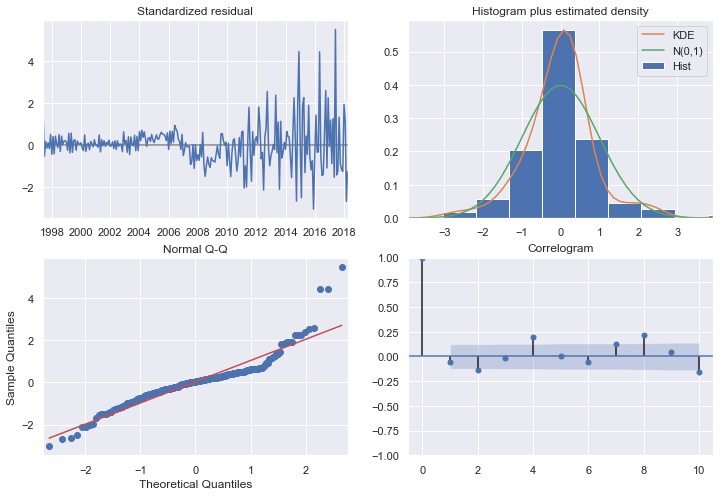

In [207]:
summarize_model(mod1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20017   No. Observations:                  265
Model:             SARIMAX(2, 0, 2)x(1, 0, 0, 12)   Log Likelihood               -2008.262
Date:                            Tue, 20 Aug 2019   AIC                           4028.525
Time:                                    01:33:05   BIC                           4049.677
Sample:                                04-01-1996   HQIC                          4037.037
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7222      0.045     38.512      0.000       1.635       1.810
ar.L2         -0.7208      0.045    -16.056      0.000      -0.809      -0.633
ma.L1          1.3621      0.048     28.523      0.000       1.269       1.456
ma.L2          0.7358      0.044     16.806      0.000       0.650       0.822
ar.S.L12      -0.0063      0.051     -0.123      0.902      -0.107       0.094
sigma2      6.319e+05   5.13e-08   1.23e+13      0.000    6.32e+05    6.32e+05
===================================================================================
Ljung-Box (Q):                       97.45   Jarque-Bera (JB):               110.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.48   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.41e+28. Standard errors may be unstable.
"""

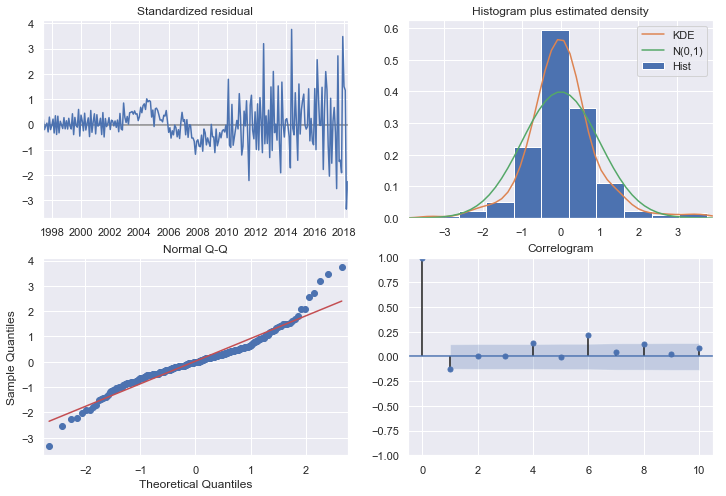

In [208]:
summarize_model(mod2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20018   No. Observations:                  265
Model:             SARIMAX(2, 0, 2)x(1, 0, 0, 12)   Log Likelihood               -2032.503
Date:                            Tue, 20 Aug 2019   AIC                           4077.007
Time:                                    01:33:07   BIC                           4098.160
Sample:                                04-01-1996   HQIC                          4085.519
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8713      0.036     51.567      0.000       1.800       1.942
ar.L2         -0.8707      0.037    -23.832      0.000      -0.942      -0.799
ma.L1          0.8287      0.042     19.938      0.000       0.747       0.910
ma.L2          0.1855      0.057      3.269      0.001       0.074       0.297
ar.S.L12      -0.0270      0.022     -1.229      0.219      -0.070       0.016
sigma2       5.85e+05   3.72e-08   1.57e+13      0.000    5.85e+05    5.85e+05
===================================================================================
Ljung-Box (Q):                      159.99   Jarque-Bera (JB):               202.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              27.38   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+28. Standard errors may be unstable.
"""

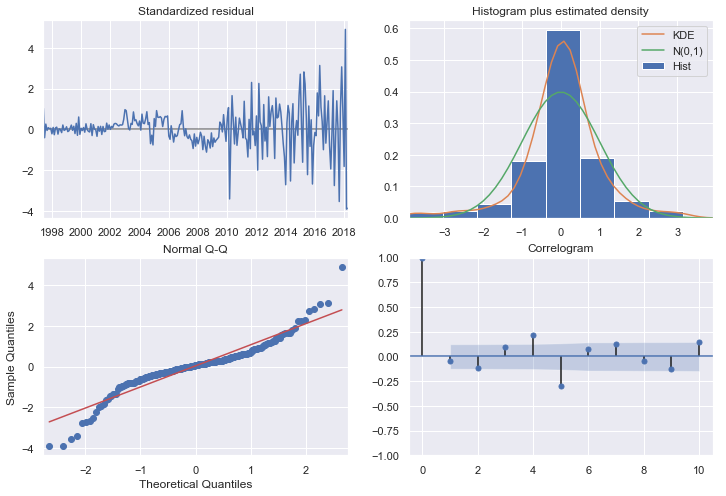

In [209]:
summarize_model(mod3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20002   No. Observations:                  265
Model:             SARIMAX(2, 0, 2)x(1, 0, 0, 12)   Log Likelihood               -2037.830
Date:                            Tue, 20 Aug 2019   AIC                           4087.660
Time:                                    01:33:09   BIC                           4108.813
Sample:                                04-01-1996   HQIC                          4096.173
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9354      0.024     79.781      0.000       1.888       1.983
ar.L2         -0.9351      0.024    -38.290      0.000      -0.983      -0.887
ma.L1          0.4556      0.044     10.301      0.000       0.369       0.542
ma.L2         -0.1570      0.042     -3.767      0.000      -0.239      -0.075
ar.S.L12      -0.0528      0.025     -2.072      0.038      -0.103      -0.003
sigma2      5.409e+05      3e-08    1.8e+13      0.000    5.41e+05    5.41e+05
===================================================================================
Ljung-Box (Q):                      164.73   Jarque-Bera (JB):                79.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.39   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+28. Standard errors may be unstable.
"""

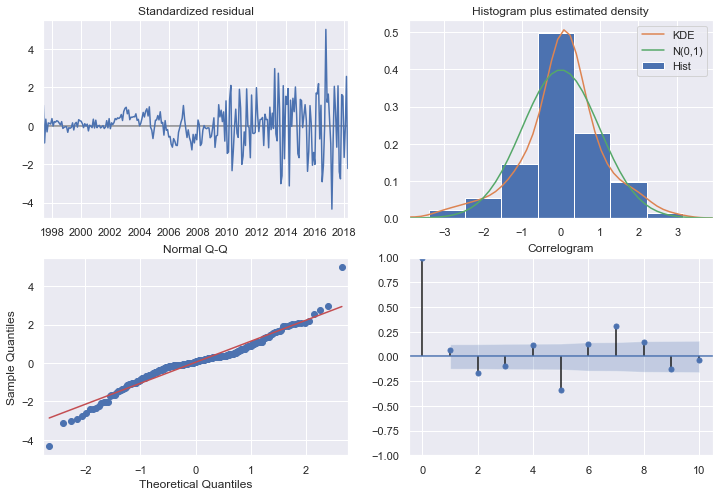

In [210]:
summarize_model(mod4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              20001   No. Observations:                  265
Model:             SARIMAX(2, 0, 2)x(1, 0, 0, 12)   Log Likelihood               -2076.557
Date:                            Tue, 20 Aug 2019   AIC                           4165.113
Time:                                    01:33:11   BIC                           4186.266
Sample:                                04-01-1996   HQIC                          4173.626
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6977      0.048     35.125      0.000       1.603       1.792
ar.L2         -0.6960      0.049    -14.308      0.000      -0.791      -0.601
ma.L1          1.3866      0.036     38.909      0.000       1.317       1.456
ma.L2          0.7205      0.036     19.802      0.000       0.649       0.792
ar.S.L12      -0.0118      0.043     -0.272      0.786      -0.097       0.073
sigma2      8.887e+05   3.43e-08   2.59e+13      0.000    8.89e+05    8.89e+05
===================================================================================
Ljung-Box (Q):                       85.29   Jarque-Bera (JB):                42.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.71   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.06e+28. Standard errors may be unstable.
"""

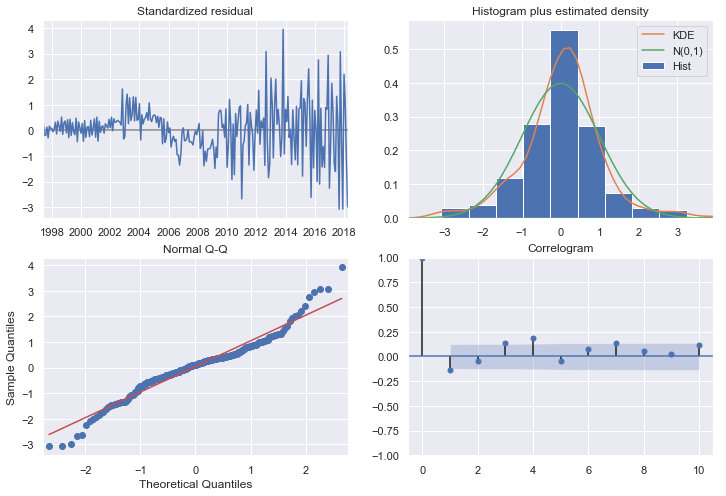

In [211]:
summarize_model(mod5)

## Validate forecasts

In [186]:
output = sarimax(cross_validation[20032], mod1.get('order'), mod1.get('sorder'))


In [201]:
def validate_forecast(ts_all, zipcode, model_dict):
    output = sarimax(ts_all[20032], model_dict.get('order'), model_dict.get('sorder'))
    pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    train, test = train_test_split(ts_all, 12)
    ax = test[zipcode]['2017-06':].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], 
                    color='g', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel(f'Housing Value for {zipcode}')
    plt.legend()

    plt.show()

Train Test Split Complete 
Length of Train: 253 	Length of Test: 12


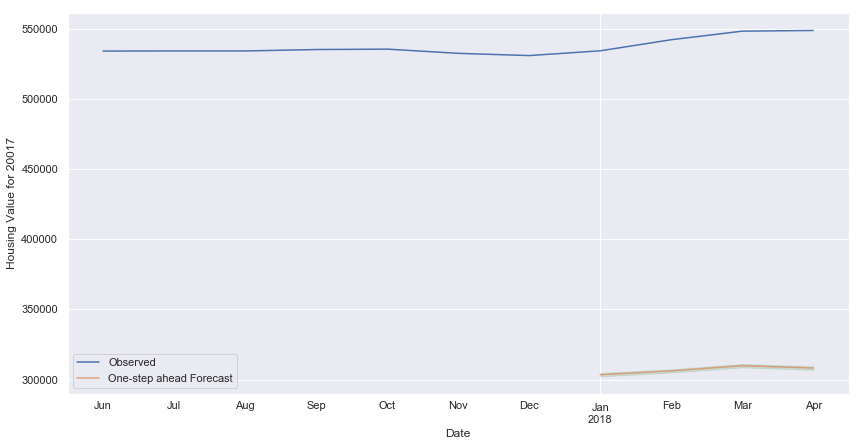

In [203]:
validate_forecast(ts_all, 20017, mod2)

In [189]:
output = sarimax(ts_all[20032], mod1.get('order'), mod1.get('sorder'))

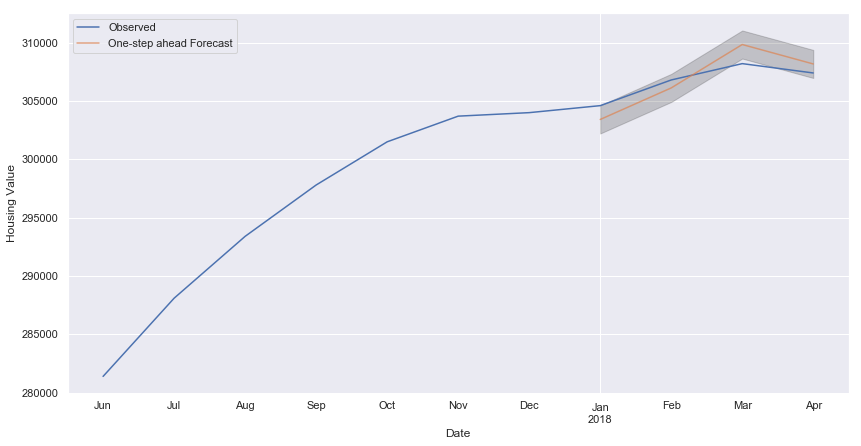

In [190]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = test[20032]['2017-06':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Housing Value')
plt.legend()

plt.show()

## Calculate ROIs

I will determine the best zipcodes to invest in as those with the highest ROI for 2 years. 

In [ ]:
def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = ((final_value - investment) / investment)
    return roi

In [89]:
def forecast_model(ts, params, display=True):
    order, sorder, trend = params
    model = sm.tsa.statespace.SARIMAX(ts, order=order, seasonal_order=sorder, trend=trend, 
                                      enforce_invertibility=False, enforce_stationarity=False)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2023-04', dynamic=True)
    conf_int = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(conf_int.index,conf_int.iloc[:, 0],conf_int.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_2= (1+output.predicted_mean[:24]).prod()-1
    year_3= (1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

In [222]:
mods

[{'zipcode': 20032, 'order': (2, 0, 2), 'sorder': (1, 0, 0, 12)},
 {'zipcode': 20017, 'order': (2, 0, 2), 'sorder': (1, 0, 0, 12)},
 {'zipcode': 20018, 'order': (2, 0, 2), 'sorder': (1, 0, 0, 12)},
 {'zipcode': 20002, 'order': (2, 0, 2), 'sorder': (1, 0, 0, 12)},
 {'zipcode': 20001, 'order': (2, 0, 2), 'sorder': (1, 0, 0, 12)}]

In [224]:
ts20032 = ts_all[20032]
o,s,t = mod1.get('order'), mod1.get('sorder'), mod1.get('trend')

In [226]:
ts20032['2018-01':]

Month
2018-01-01   304600.0
2018-02-01   306800.0
2018-03-01   308200.0
2018-04-01   307400.0
Name: 20032, dtype: float64

return on investment = (gain from investment — cost of investment) / cost of investment

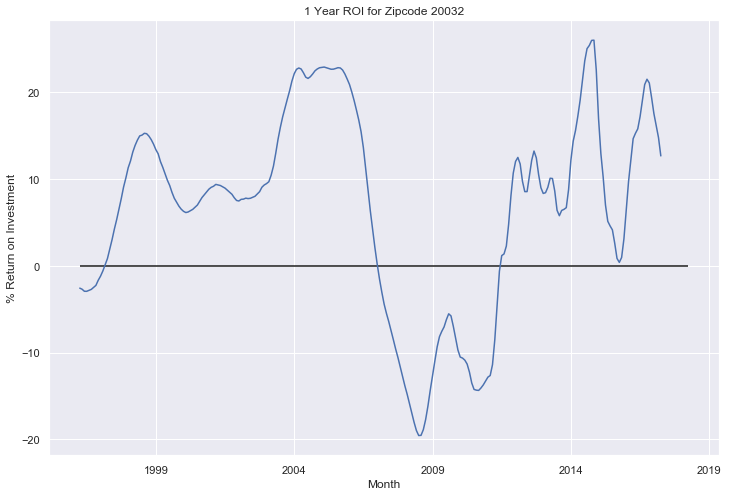

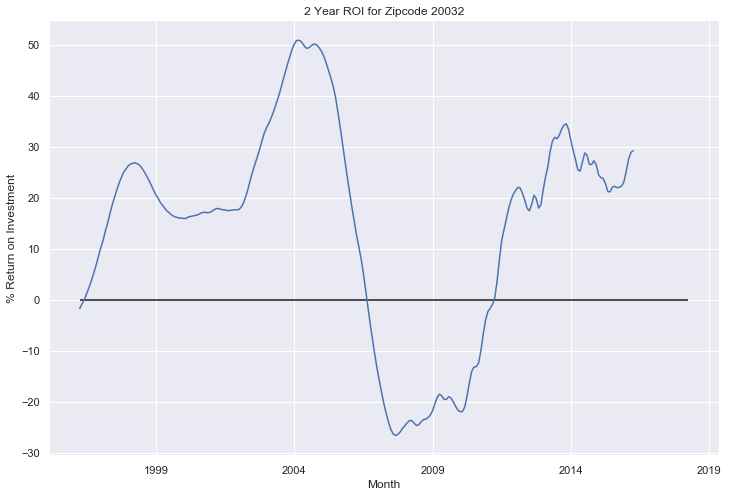

In [237]:
#Calculate and plot 1 year ROI
#tshift shifts index (dates)
ROI_1yr = 100 * (ts20032.tshift(-12) / ts20032 - 1)
ROI_1yr.plot(figsize=(12,8))
plt.hlines(0, ts20032.index[0], ts20032.index[-1])
plt.ylabel('% Return on Investment')
plt.title('1 Year ROI for Zipcode 20032')
plt.show();
ROI_1yr = 100 * (ts20032.tshift(-24) / ts20032 - 1)
ROI_1yr.plot(figsize=(12,8))
plt.hlines(0, ts20032.index[0], ts20032.index[-1])
plt.ylabel('% Return on Investment')
plt.title('2 Year ROI for Zipcode 20032')
plt.show();

In [118]:
year_1= (1+output.predicted_mean[:12]).prod()-1
year_1

3.4635092776267793e+71

In [ ]:
#Put ROI data into dataframe
roi_df = pd.DataFrame(roi_list)
roi_df.drop(columns=['model'],inplace=True)
roi_df.head()

results_df = pd.DataFrame(roi_df)
results_df.drop(columns=['model'],inplace=True)
results_df.head()

## Visualize predictions

In [238]:
model = sm.tsa.statespace.SARIMAX(ts20032, order=o, seasonal_order=s, enforce_invertibility=False, enforce_stationarity=False)
model_fit = model.fit()

In [239]:
output = model_fit.get_prediction(start='2018-04',end='2020-04', dynamic=True)
conf_int = output.conf_int()

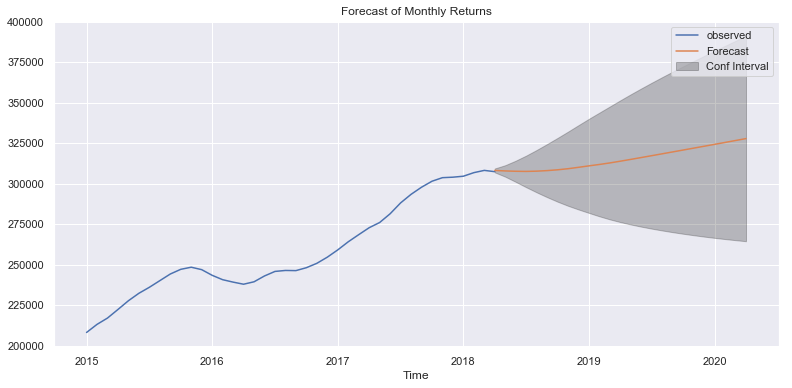

In [241]:
fig, ax = plt.subplots(figsize=(13,6))
ax = ts20032['2015-01':].plot(label='observed')
output.predicted_mean.plot(label='Forecast')
ax.fill_between(conf_int.index,conf_int.iloc[:, 0],conf_int.iloc[:, 1],
                color='k', alpha=.25,label='Conf Interval')
plt.title('Forecast of Monthly Returns')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

In [48]:
sorted_results_1yr = sorted(results,key=lambda x: x['ROI_1yr'],reverse=True)
results_1yr_df = pd.DataFrame(sorted_results_1yr)
results_1yr_df.drop(columns=['model'],inplace=True)
results_1yr_df.head()

,ROI_1yr,ROI_2yr,city,zipcode
0,0.093,0.151,"Washington,DC",20001
1,0.089,0.104,"Washington,DC",20032
2,0.074,0.156,"Washington,DC",20024
3,0.065,0.132,"Washington,DC",20007
4,0.044,0.080,"Washington,DC",20010


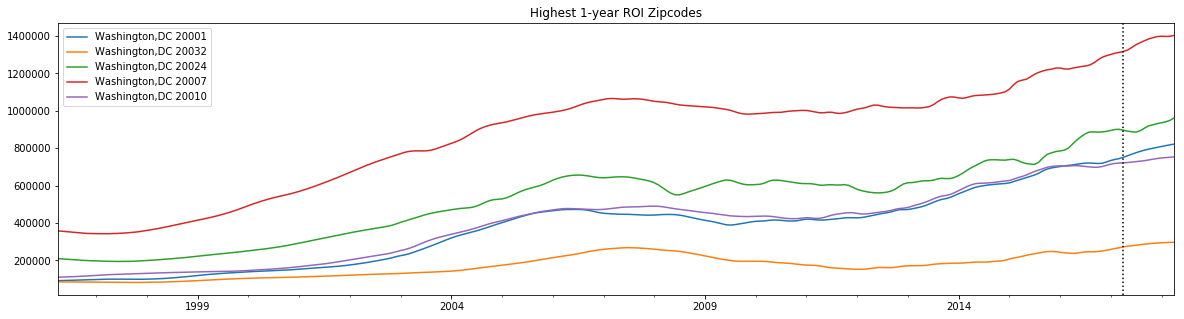

In [49]:
plot_forecasts(z_train,sorted_results_1yr[0:5],steps=12,title='Highest 1-year ROI Zipcodes')

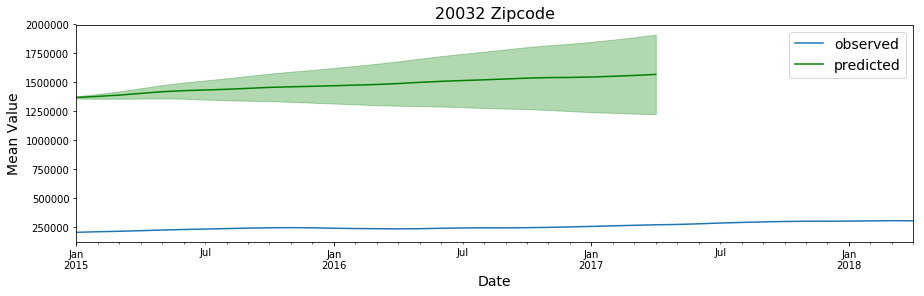

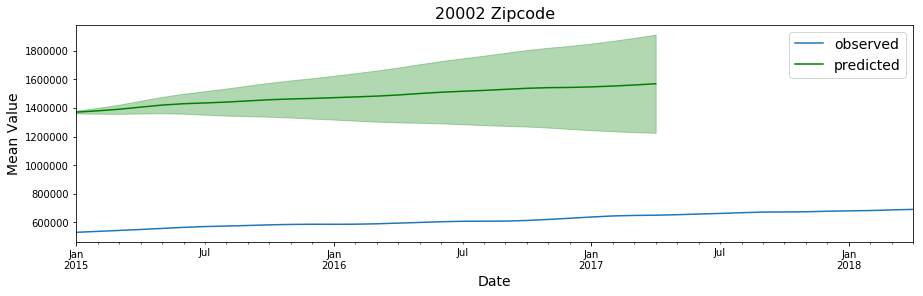

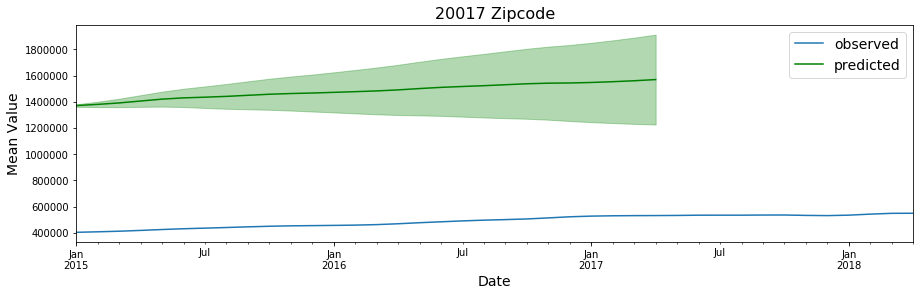

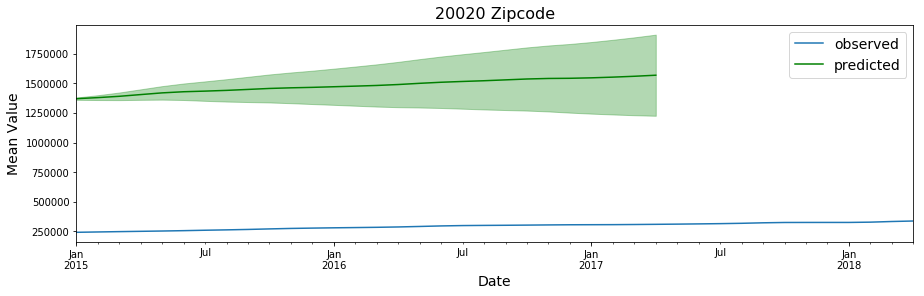

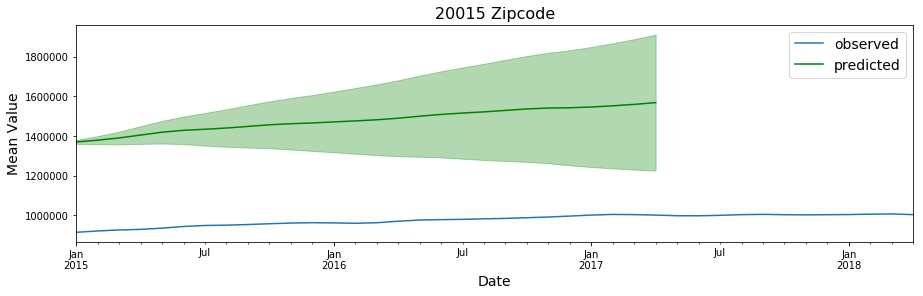

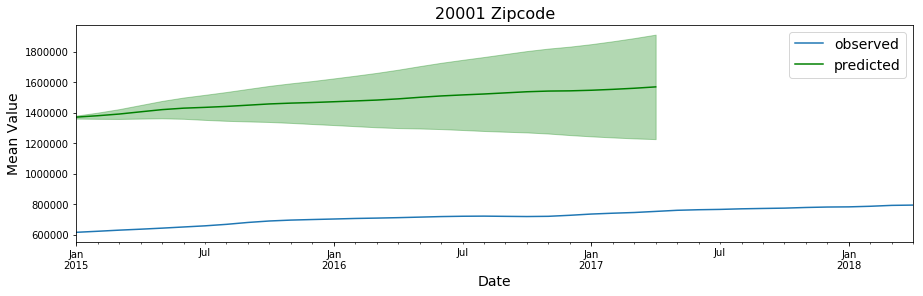

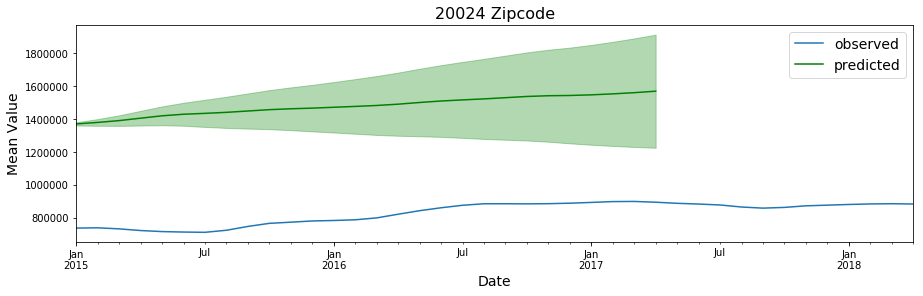

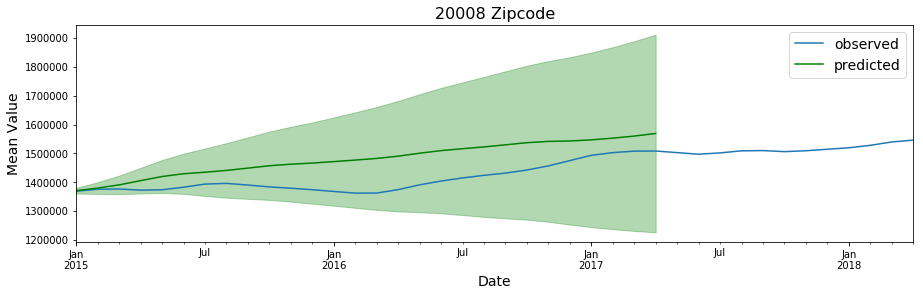

In [39]:
for zipcode in test_best_results.zipcode:
    #Get predictions starting from 2016 and calculate confidence intervals.
    prediction = output.get_prediction(start=pd.to_datetime('2015-01'), dynamic=True)
    pred_conf = prediction.conf_int()
    plot_predictions(ts_all[zipcode]['2015-01':], zipcode, prediction, pred_conf)

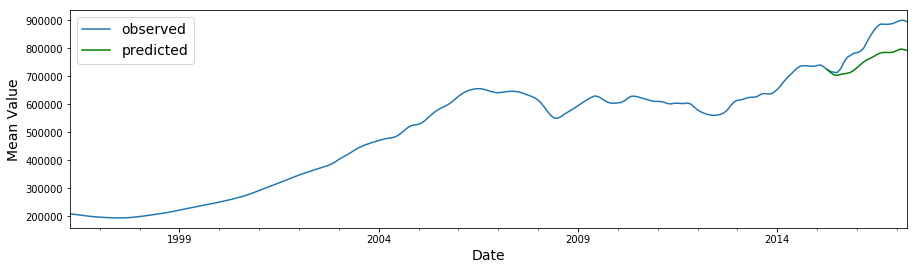

In [76]:
z_train[20024].plot(label='observed')

# Plot predicted values
pred_price = prediction.predicted_mean
pred_price.plot(figsize=(15,4),color='g', label='predicted')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Mean Value', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

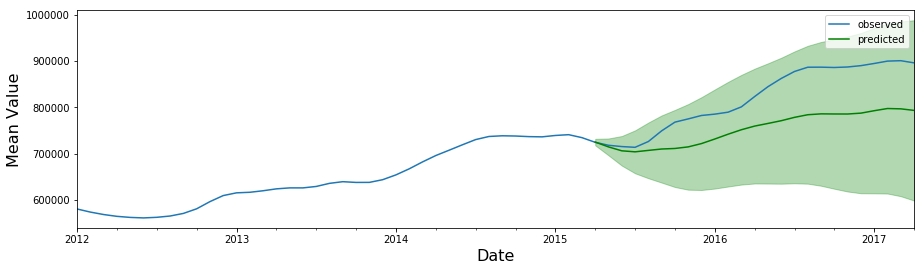

In [79]:
# Plot observed values
z_train[z][20024]['2012-01':].plot(label='observed')

# Plot predicted values
prediction.predicted_mean.plot(figsize=(15,4),color='g', label='predicted')

# Plot the range for confidence intervals
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.3)

# Set axes labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mean Value', fontsize=16)
plt.legend();

In [80]:
prediction_models = []
for zipcode in z:
    model = plot_predictions(z_train[zipcode], zipcode, pdq)
    prediction_models.append(model)

NameError: name 'pdq' is not defined

In [ ]:
from matplotlib.pylab import rcParams

In [156]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = train['2014':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()

NameError: name 'rcParams' is not defined

In [157]:
test_forecasted = pred.predicted_mean
test_truth = train['2017':].value
test_forecasted = test_forecasted['2017':]
# Compute the root mean square error
error = mean_squared_error(test_forecasted, test_truth)
error = np.sqrt(error)
print(f'The RMSE of our forecasts is {error}')

NameError: name 'pred' is not defined

In [151]:
def plot_predictions(df, label, prediction, pred_conf):
    '''
    Plot time series, predicted mean line, and prediction
    confidence intervals.
    
    Input: 
        df - dataframe
        label - zipcode 
        predictions
        prediction confidence intervals
    '''
    # Plot observed values
    df['2012':].plot(label='observed')
    
    # Plot predicted values
    pred_price = prediction.predicted_mean
    pred_price.plot(figsize=(15,4),color='g', label='predicted')
    
    # Plot the range for confidence intervals
    pred_conf_usd = pred_conf
    plt.fill_between(pred_conf_usd.index,
                    pred_conf_usd.iloc[:, 0],
                    pred_conf_usd.iloc[:, 1], color='g', alpha=.3)
    
    # Set axes labels
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mean Value', fontsize=14)
    plt.title(f"{label} Zipcode", fontsize=16)
    plt.legend(loc='best', fontsize=14)
    plt.show()

In [152]:
def model_forecast(ts,model,steps,plot=False):
    '''
    Get an ROI 1-yr and 2-yr using a forecast with the time series and model provided.
    
    Input:
         ts - The time series being forecasted.
         model - The model being used to make a forecast.
         steps - The number of steps ahead to forecast.
         plot - If True, plot the forecast
         
    Return:
         Dictionary containing 1-yr and 2-yr ROI values.  
    '''
    #Get prediction values for given number of steps
    prediction = model.get_forecast(steps=steps)
    #Get confidence interval
    pred_conf = prediction.conf_int()
    
    if plot:    
        #Plot future prediction with confidence interval
        ax = ts.plot(label='observed',figsize=(20,5))
        prediction.predicted_mean.plot(ax=ax,label='forecast')
        ax.fill_between(pred_conf.index,pred_conf.iloc[:,0],pred_conf.iloc[:,1],color='b',alpha=0.1)
        plt.legend(loc='upper left')
        plt.show()
    
    #At least 60 steps are required in order to calculate the 5-yr ROI
    if steps <= 60:
        prediction = model.get_forecast(steps=60)
    
    #Calculate 1yr and 2yr ROIs
    last_val = ts[-1]
    roi_1yr = round((prediction.predicted_mean[11] - last_val)/last_val , 3)
    roi_2yr = round((prediction.predicted_mean[23] - last_val)/last_val , 3)
    
    return {'ROI_1yr':roi_1yr, 'ROI_2yr': roi_2yr}

In [153]:
def plot_forecasts(df, model_dicts, steps, title=None):
    '''
    Plot forecasts for all zipcodes in results dictionary.
    
    Arguments:
         df         = The dataframe containing time series data with zipcodes as column names.
         model_dict = List containing dictionaries with models for each zipcode.
         steps      = The number of steps ahead to forecast.
         
    Return Value:
         A plot with all zipcodes in model_dicts  
    '''
    
    for item in model_dicts:
        zipcode = item['zipcode']
        label = f"{item['city']} {zipcode}"
        model = item['model']
        ts = df[zipcode]
        prediction = model.model_forecast(steps=steps)
        all_data = pd.concat([ts,prediction.predicted_mean],axis=0)
        ax = all_data.plot(label=label,figsize=(20,5))
    
    plt.axvline(x=df.index[-1], color='black', linestyle=':')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    return

In [154]:
def pacf_plot(ts,lags=100):
    fig, ax = plt.subplots(figsize=(15,5))
    sm.graphics.tsa.plot_pacf(ts, ax=ax, lags=lags)
    return


def acf_plot(ts,lags=100):
    fig, ax = plt.subplots(figsize=(15,5))
    sm.graphics.tsa.plot_acf(ts, ax=ax, lags=lags)
    return

In [155]:
def calculate_roi(train, best_results_df, raw_df, sort='ROI_2yr', steps=24):
    results = []
    #Iterate through zipcodes
    for zipcode in train.columns:
        #Get best parameters from dataframe
        order,sorder,t = extract_params(best_results_df, zipcode)
        zipcode_model = sarimax_model(train[zipcode].dropna(),order,sorder)['model']
        if zipcode_model==None:
            continue
        result = model_forecast(train[zipcode],zipcode_model,steps,plot=False)
        result['zipcode'] = zipcode
        result['model'] = zipcode_model
        location_info = raw_df.loc[raw_df.RegionName==zipcode,['City','State']].values
        label = f"{location_info[0][0]},{location_info[0][1]}"
        result['city'] = label
        results.append(result)
    results = sorted(results,key=lambda x: x[sort],reverse=True)
    return results

Resources:

https://www.mikulskibartosz.name/nested-cross-validation-in-time-series-forecasting-using-scikit-learn-and-statsmodels/

https://medium.com/@abhikjha/predicting-sensex-48f4afb900b5

https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/